## Import the libraries

In [1]:
import operator
from typing import List, TypedDict, Annotated,Sequence
from pydantic import BaseModel, Field
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langgraph.graph import StateGraph,END

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

True

#### Load the keys

In [3]:
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
os.environ["Google_API_KEY"]= os.getenv("Google_API_KEY")
os.environ["HF_TOKEN"] = os.getenv("HF_TOKEN")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")

### Define the websearch tool

In [4]:
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults()

In [5]:
tavily_search.invoke({"query":"Adolf hitler"})[0]['content']

'**Adolf Hitler**[[a]](#cite_note-1) (20 April 1889 – 30 April 1945) was an Austrian-born German politician who was the dictator of [Nazi Germany](/wiki/Nazi_Germany "Nazi Germany") from 1933 until [his suicide](/wiki/Death_of_Adolf_Hitler "Death of Adolf Hitler") in 1945. [He rose to power](/wiki/Adolf_Hitler%27s_rise_to_power "Adolf Hitler\'s rise to power") as the leader of the [Nazi Party](/wiki/Nazi_Party "Nazi Party"),[[c]](#cite_note-3) becoming [the [...] | Adolf Hitler | |\n| --- | --- |\n| [Black-and-white photographic portrait of Hitler standing](/wiki/File:Hitler_portrait_crop.jpg) Hitler in 1938 | |\n|  | |\n| [*Führer* of Germany](/wiki/F%C3%BChrer "Führer") | |\n| **In office** 2 August 1934\xa0– 30 April 1945 | |\n| Preceded by | [Paul von Hindenburg](/wiki/Paul_von_Hindenburg "Paul von Hindenburg") (as [President](/wiki/President_of_Germany_(1919%E2%80%931945) "President of Germany (1919–1945)")) | [...] Adolf Hitler was born on 20 April 1889 in [Braunau am Inn](/wiki/

### Defining LLM_model, validation_model

#### LLM Model

In [6]:
from langchain_groq import ChatGroq
llm_model = ChatGroq(model= "deepseek-r1-distill-llama-70b")

In [7]:
llm_model.invoke("hi").content

'<think>\n\n</think>\n\nHello! How can I assist you today? 😊'

#### Validation Model

In [8]:
validation_model = ChatGroq(model = "gemma2-9b-it")
validation_model.invoke("hi").content

'Hi there! 👋  What can I do for you today?\n'

### Creating a Pydantic Class

In [9]:
class TopicSelectionParser(BaseModel):
    Topic:str = Field(description="Selected Topic")
    Reasoning:str= Field(description="Reasoning behind topic selection")

In [10]:
from langchain.output_parsers import PydanticOutputParser
parser = PydanticOutputParser(pydantic_object=TopicSelectionParser)
parser.get_format_instructions()

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"Topic": {"description": "Selected Topic", "title": "Topic", "type": "string"}, "Reasoning": {"description": "Reasoning behind topic selection", "title": "Reasoning", "type": "string"}}, "required": ["Topic", "Reasoning"]}\n```'

### Use vivekanand text data, embed it and store it in vectorDB

In [11]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings()

c:\Projects\Agentic_AI_2.0_Course\AGENTIC_AI_2.0\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
from langchain_community.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma

In [13]:
loader = TextLoader('swami_vivekanand.txt')
document = loader.load()
document

[Document(metadata={'source': 'swami_vivekanand.txt'}, page_content="Swami Vivekananda was a Hindu monk and a key figure in the introduction of Vedanta philosophy to the Western world. Born as Narendra Nath Datta on January 12, 1863, in Kolkata, India, he was heavily influenced by the teachings of Ramakrishna, a 19th-century mystic, and went on to become one of the most influential spiritual leaders of his time.\n\nVivekananda travelled extensively across India, giving lectures and spreading his message of unity and human dignity. He was a strong advocate of India's ancient spiritual culture and promoted the idea of universal peace and harmony. He believed that all religions were paths to reach the same ultimate goal, and that a person's individual religion was a matter of personal choice.\n\nIn 1893, Vivekananda represented India at the World Parliament of Religions in Chicago. His speeches, delivered in English, were well received and made a lasting impression on the Western audience

In [14]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=100, chunk_overlap = 20)
docs = text_splitter.split_documents(document)

In [15]:
db= Chroma.from_documents(docs, embeddings)
retriever = db.as_retriever(search_kwargs={"k":3})
output = retriever.invoke("who was vivekanand?")


In [16]:
output[2].page_content

'Swami Vivekananda was a great spiritual leader and philosopher who left a lasting impact on the'

################################################################################

### Create an agent state inside StateGrpah

In [17]:
class AgentState(TypedDict):
    messages:Annotated[Sequence[BaseMessage], operator.add]

### Create supervisor function

In [18]:
def supervisor_fn(state:AgentState):
    print("--Supervisor node---")
    
    user_query = state["messages"][-1]
    print("User query", user_query)
    
    template =""" 
    Your task is to classify the user query into one of the following categories.[Swami vivekanand, Web search, LLM]
    Swami vivekanand = if the user query is related to swami vivekanand, then put it in this category.
    Web search = if user query needs web search, then put it in this category
    LLM : if the user query can be answered by LLM, then put it in this category
    
    user_query:{user_query},
    {format_instructions}
    """
    
    prompt = PromptTemplate(
        template=template,
        input_variables=["user_query"],
        partial_variables={"format_instructions":parser.get_format_instructions()}
    )
    
    chain = prompt| llm_model | parser
    
    response = chain.invoke({"user_query":user_query})
    
    print("Parsed output:", response)
    
    print(state["messages"][-1])
    
    return {"messages": [response.Topic]}

    
    

### Create LLM Function

In [19]:
def LLM_fn(state:AgentState):
    print("---> LLM Function --->")
    user_query = state["messages"][0]
    
    # normal LLM call
    complete_query = "Answer the following query based on your knowledge of real world. Following is the user query" + user_query
    response = llm_model.invoke(complete_query)
    return {"messages":[response.content]}
    

### Create the Web Search Tool function

In [20]:
def webSearch_fn(state:AgentState):
    print("---> Web search Call --->")
    user_query = state["messages"][0]
    
    response = tavily_search.invoke(user_query)
    return {"messages": [response.content]}

### format_doc

In [21]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs )

### Create a RAG Function

In [22]:
def Rag_fn(state:AgentState):
    print("---> RAG Call--->")
    user_query = state["messages"][0]
    
    template =""" 
    You are an AI assistant for question answering task.Use the following piece of retrieved context to answer the user query.If you don't know the answer, just say you don't know.Use three sentences maximum and keep the answer concise.\nUser_query:{user_query}\ncontext:{context} \nAnswer,
    """
    
    prompt = PromptTemplate(
        template=template,
        input_variables=['context','user_query']
    )
    
    rag_chain =(
        {"context":retriever|format_docs, "user_query":RunnablePassthrough()}
        | prompt
        | llm_model
        | StrOutputParser()
    )
    
    result = rag_chain.invoke(user_query)
    
    return {"messages": [result]}

### Crete a Router

In [23]:
def router(state:AgentState):
    print("---> Supervisor router --->")
    
    last_message = state["messages"][-1]
    
    if "swami" in last_message.lower():
        return "RAG call"
    elif "llm" in last_message.lower():
        return "LLM call"
    else:
        return "Websearch call"
        

## Create a validation function

In [24]:
def Validation_fn(state:AgentState):
    print("---> Validation Call --->")
    
    user_query = state["messages"][0]
    answer = state["messages"][-1]
    
    template = """You are a validation assistant and your job is to check whether the answer provided for 
    user query is correct or not. Return the result as categories [Approved, Not Approved]
    Approved: if the answer looks correct for the question
    Not Approved:if the answer does not look correct for the question
    
    user_query={user_query}
    answer={answer}"""
    
    prompt = PromptTemplate(
        template=template,
        input_variables=["user_query","answer"]
    )
    
    chain = prompt | validation_model
    
    res = None
    try:
        response = chain.invoke({"user_query":user_query,"answer":{answer}})
        res = "Approved" if "approved" in response.content.lower() else "Denied"
    except Exception as e:
        print(e)
        
    return {"messages":[res]}   

### Create validation router

In [25]:
def validation_router(state:AgentState):
    print("---> Validation router --->")
    
    last_message = state["messages"][-1]
    print("Validation report",last_message)
    
    if "Approved" in last_message:
        return "Approved"
    else:
        return "Denied"

In [26]:
def end_function(state:AgentState):
    final_answer = state["messages"][2]
    print("final answer", final_answer)
    print("workflow completed")
    return {"messages":[state["messages"][-1]]}

## Create the workflow

In [27]:
from langgraph.graph import StateGraph,END

workflow = StateGraph(AgentState)
workflow.add_node("Supervisor", supervisor_fn)
workflow.add_node("RAG", Rag_fn)
workflow.add_node("LLM", LLM_fn)
workflow.add_node("WebSearch", webSearch_fn)
workflow.add_node("Validation",Validation_fn)

workflow.set_entry_point("Supervisor")
workflow.add_node("END", end_function)


workflow.add_conditional_edges(
    "Supervisor",
    router,
    {
       "RAG call":"RAG",
       "LLM call":"LLM",
       "Websearch call":"WebSearch",       
    }
)

workflow.add_edge("RAG","Validation")
workflow.add_edge("LLM","Validation")
workflow.add_edge("WebSearch","Validation")

workflow.add_conditional_edges(
    "Validation",
    validation_router,
    {
        "Approved":"END",
        "Denied":"Supervisor"
    }
)

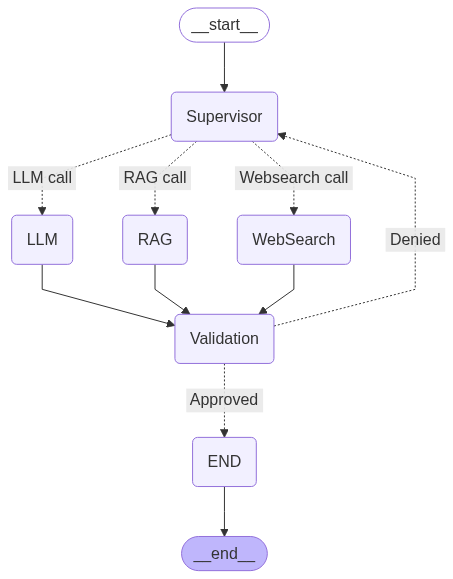

In [28]:
app=workflow.compile()
app

In [29]:
state = {"messages":["hello"]}
app.invoke(state)

--Supervisor node---
User query hello
Parsed output: Topic='LLM' Reasoning='The query is a simple greeting, which can be handled by the LLM without needing specific information about Swami Vivekanand or requiring a web search.'
hello
---> Supervisor router --->
---> LLM Function --->
---> Validation Call --->
---> Validation router --->
Validation report Approved
final answer <think>
Okay, the user just said "hello." I should respond in a friendly and approachable way. Maybe say hello back and ask how I can assist them today. Keep it simple and open-ended to encourage them to share what they need help with.
</think>

Hello! How can I assist you today?
workflow completed


{'messages': ['hello',
  'LLM',
  '<think>\nOkay, the user just said "hello." I should respond in a friendly and approachable way. Maybe say hello back and ask how I can assist them today. Keep it simple and open-ended to encourage them to share what they need help with.\n</think>\n\nHello! How can I assist you today?',
  'Approved',
  'Approved']}